# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, isnan, when, count, asc, desc, concat
from pyspark.sql.types import StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.conf import SparkConf

from sklearn.utils import parallel_backend
from sklearn.pipeline import Pipeline as sk_pipe
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder \
    .master("local[5]") \
    .appName("Churn Prediction") \
    .config("spark.driver.memory", '1g') \
    .config("spark.executor.cores", '5') \
    .config("spark.shuffle.file.buffer", '1mb') \
    .config("spark.sql.shuffle.partitions", '5') \
    .getOrCreate()

spark.sparkContext

<SparkContext master=local[5] appName=Churn Prediction>

In [3]:
conf = SparkConf()
conf.getAll()

[('spark.shuffle.file.buffer', '1mb'),
 ('spark.app.submitTime', '1661175364022'),
 ('spark.sql.shuffle.partitions', '5'),
 ('spark.executor.cores', '5'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.name', 'Churn Prediction'),
 ('spark.master', 'local[5]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '1g'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df_ = df.toPandas()

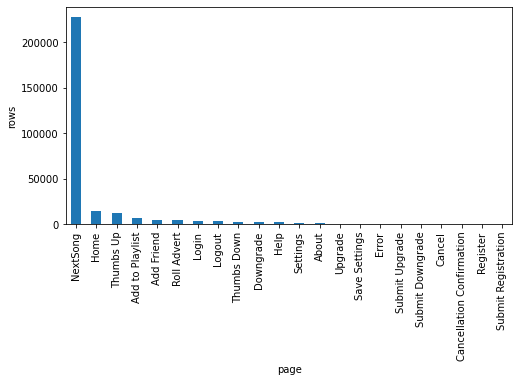

In [18]:
plt.figure(figsize=(8,4))
df_['page'].value_counts().plot(kind='bar')
plt.xlabel('page')
plt.ylabel('rows')
plt.show();

In [12]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [9]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
df.count()

286500

In [13]:
summary = df.summary().toPandas()
summary

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.11718197783568,None,None,None,None,1.5353588340855662E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104355E12,None,59682.02278593872
2,stddev,1217.7693079161377,None,None,None,129.767262011411,None,99.23517921058324,None,None,None,None,3.291321616327608E9,726.7762634630808,NaN,31.50507848842206,1.5075439608245337E9,None,109091.94999910511
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,25%,311.0,None,None,None,27,None,199.88853,None,None,None,None,1533522419000,336,24.0,200,1539696833000,None,51.0
5,50%,311.0,None,None,None,70,None,234.47465,None,None,None,None,1536663902000,1013,221.0,200,1540931743000,None,98.0
6,75%,311.0,None,None,None,156,None,277.15873,None,None,None,None,1537672236000,1675,1958.0,200,1542265558000,None,100004.0
7,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [14]:
df.distinct().count()

286500

There are no duplicate rows.

In [15]:
df.select('firstName', 'auth', 'level', 'registration', 'userId', 'sessionId', 'page').filter(df.userId == '').show()

+---------+----------+-----+------------+------+---------+-----+
|firstName|      auth|level|registration|userId|sessionId| page|
+---------+----------+-----+------------+------+---------+-----+
|     null|Logged Out| free|        null|      |        8| Home|
|     null|Logged Out| free|        null|      |        8| Help|
|     null|Logged Out| free|        null|      |        8| Home|
|     null|Logged Out| free|        null|      |        8|Login|
|     null|Logged Out| free|        null|      |      240| Home|
|     null|Logged Out| free|        null|      |      240|Login|
|     null|Logged Out| free|        null|      |      100|Login|
|     null|Logged Out| free|        null|      |      241|Login|
|     null|Logged Out| free|        null|      |      187| Home|
|     null|Logged Out| free|        null|      |      187|Login|
|     null|Logged Out| free|        null|      |      187| Home|
|     null|Logged Out| free|        null|      |      187| Home|
|     null|Logged Out| fr

In [16]:
df.filter(df.userId == '').count()

8346

In [20]:
df.select('firstName', 'auth', 'level', 'registration', 'userId', 'sessionId', 'page').filter((col('userId') == '') & (col('level') == 'paid')).show()

+---------+----------+-----+------------+------+---------+-----+
|firstName|      auth|level|registration|userId|sessionId| page|
+---------+----------+-----+------------+------+---------+-----+
|     null|Logged Out| paid|        null|      |      141| Home|
|     null|Logged Out| paid|        null|      |      141|Login|
|     null|Logged Out| paid|        null|      |      141| Home|
|     null|Logged Out| paid|        null|      |      141|Login|
|     null|Logged Out| paid|        null|      |      248| Home|
|     null|Logged Out| paid|        null|      |      248|Login|
|     null|Logged Out| paid|        null|      |      237|Login|
|     null|Logged Out| paid|        null|      |      141| Home|
|     null|Logged Out| paid|        null|      |      141|Login|
|     null|Logged Out| paid|        null|      |      236| Home|
|     null|Logged Out| paid|        null|      |      236| Home|
|     null|Logged Out| paid|        null|      |      236| Home|
|     null|Logged Out| pa

In [21]:
df.select('page').filter((col('userId') == '') & (col('level') == 'paid')).distinct().show()

+-----+
| page|
+-----+
|Login|
|About|
| Home|
| Help|
|Error|
+-----+



In [22]:
df.filter((col('userId') == '') & (col('level') == 'paid')).count()

5729

In [23]:
df.filter((col('userId') == '') & (col('level') == 'free')).count()

2617

In [24]:
df.select('registration').filter((col('level') == 'paid') & (col('userId') == '')).distinct().show()

+------------+
|registration|
+------------+
|        null|
+------------+



In [25]:
df.select('firstName').filter(col('userId') == '').distinct().show()

+---------+
|firstName|
+---------+
|     null|
+---------+



In [26]:
df.select('page').filter(col('userId') == '').distinct().show()

+-------------------+
|               page|
+-------------------+
|              Login|
|              About|
|               Home|
|               Help|
|              Error|
|           Register|
|Submit Registration|
+-------------------+



Users without a `userId` had never listened to a song nor had registered. For that reason I will drop these rows.

In [27]:
df_clean = df.where(col('userId') != '')
df_clean.count()

278154

In [28]:
df_clean.filter(col('userId') == '').show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [29]:
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|           Downgrade|
|         Thumbs Down|
|               About|
|              Cancel|
|            NextSong|
|     Add to Playlist|
|           Thumbs Up|
|                Home|
|               Error|
|       Save Settings|
|    Submit Downgrade|
|Cancellation Conf...|
|              Logout|
|          Add Friend|
|            Settings|
|         Roll Advert|
|                Help|
|             Upgrade|
|      Submit Upgrade|
+--------------------+



In [30]:
df_clean.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [31]:
df_clean.select('level').filter(col('page') == 'Cancel').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [32]:
df_clean.select('level').filter(
    (col('page') == 'Submit Downgrade') | 
    (col('page') == 'Downgrade')
).distinct().show()

+-----+
|level|
+-----+
| paid|
+-----+



In [33]:
df_clean.select('auth').filter(
    (col('page') == 'Submit Downgrade') | 
    (col('page') == 'Downgrade')
).distinct().show()

+---------+
|     auth|
+---------+
|Logged In|
+---------+



In [34]:
df_clean.select('auth').filter(col('page') == 'Cancellation Confirmation').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
+---------+



In [35]:
df_clean.select('level').filter(col('page') == 'Cancellation Confirmation').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [36]:
df_clean.select('userId').filter((col('page') == 'Cancellation Confirmation') & (col('level') == 'paid')).distinct().show()

+------+
|userId|
+------+
|   105|
|    32|
|   101|
|   121|
|    17|
|   129|
|    18|
|    51|
|    12|
|    87|
|    73|
|    58|
|     3|
|   122|
|   106|
|    53|
|    54|
|   103|
|    28|
|    29|
+------+
only showing top 20 rows



In [37]:
df_clean.select('userId').filter((col('page') == 'Cancellation Confirmation') & (col('level') == 'free')).distinct().show()

+------+
|userId|
+------+
|   125|
|   143|
|100024|
|100003|
|100005|
|100006|
|100012|
|100022|
|100017|
|100009|
|200001|
|100011|
|100001|
|100019|
|100025|
|100021|
|200011|
|200018|
|200016|
|200015|
+------+
only showing top 20 rows



In [38]:
df_clean.select('page', 'userId', 'sessionId', 'auth', 'level', 'ts').filter(col('userId') == 103).toPandas()

,page,userId,sessionId,auth,level,ts
0,NextSong,103,102,Logged In,free,1538648520000
1,Thumbs Up,103,102,Logged In,free,1538648521000
2,NextSong,103,102,Logged In,free,1538648734000
3,NextSong,103,102,Logged In,free,1538648970000
4,NextSong,103,102,Logged In,free,1538649234000
...,...,...,...,...,...,...
1305,NextSong,103,1583,Logged In,paid,1541339727000
1306,NextSong,103,1583,Logged In,paid,1541340029000
1307,Downgrade,103,1583,Logged In,paid,1541340075000
1308,Cancel,103,1583,Logged In,paid,1541340076000


In [39]:
df_clean.select('page', 'userId', 'sessionId', 'auth', 'level', 'ts').filter(col('userId') == 125).toPandas()

,page,userId,sessionId,auth,level,ts
0,NextSong,125,174,Logged In,free,1539317144000
1,NextSong,125,174,Logged In,free,1539317481000
2,NextSong,125,174,Logged In,free,1539317711000
3,NextSong,125,174,Logged In,free,1539317914000
4,NextSong,125,174,Logged In,free,1539318124000
5,NextSong,125,174,Logged In,free,1539318515000
6,NextSong,125,174,Logged In,free,1539318728000
7,NextSong,125,174,Logged In,free,1539318906000
8,Roll Advert,125,174,Logged In,free,1539318917000
9,Cancel,125,174,Logged In,free,1539318918000


It looks like the event `Cancellation Confirmation` happens when a user completely ends his account.

In [40]:
df_clean.select('userId').filter(col('page') == 'Submit Downgrade').distinct().show()

+------+
|userId|
+------+
|    12|
|   141|
|    20|
|    11|
|   131|
|    81|
|    85|
|   140|
|    54|
|    95|
|    61|
|    35|
|    77|
|    59|
|    38|
|    30|
|   103|
|    74|
|     9|
|    24|
+------+
only showing top 20 rows



In [41]:
test_user = df_clean.select('page', 'userId', 'sessionId', 'auth', 'level', 'ts').filter(col('userId') == 61).toPandas()
test_user

,page,userId,sessionId,auth,level,ts
0,Home,61,60,Logged In,free,1538445366000
1,NextSong,61,60,Logged In,free,1538446343000
2,NextSong,61,60,Logged In,free,1538446593000
3,NextSong,61,60,Logged In,free,1538446766000
4,NextSong,61,60,Logged In,free,1538447229000
...,...,...,...,...,...,...
1971,NextSong,61,2345,Logged In,paid,1543426755000
1972,NextSong,61,2345,Logged In,paid,1543426957000
1973,Downgrade,61,2345,Logged In,paid,1543427571000
1974,Submit Downgrade,61,2345,Logged In,paid,1543427572000


In [42]:
test_user.loc[test_user.page == 'Submit Downgrade']

,page,userId,sessionId,auth,level,ts
922,Submit Downgrade,61,529,Logged In,paid,1539244188000
1974,Submit Downgrade,61,2345,Logged In,paid,1543427572000


In [43]:
test_user.iloc[918:926]

,page,userId,sessionId,auth,level,ts
918,NextSong,61,529,Logged In,paid,1539243460000
919,NextSong,61,529,Logged In,paid,1539243698000
920,NextSong,61,529,Logged In,paid,1539244048000
921,Downgrade,61,529,Logged In,paid,1539244187000
922,Submit Downgrade,61,529,Logged In,paid,1539244188000
923,Home,61,529,Logged In,free,1539244611000
924,NextSong,61,529,Logged In,free,1539244655000
925,Thumbs Up,61,529,Logged In,free,1539244656000


In [44]:
test_user.iloc[1972:]

,page,userId,sessionId,auth,level,ts
1972,NextSong,61,2345,Logged In,paid,1543426957000
1973,Downgrade,61,2345,Logged In,paid,1543427571000
1974,Submit Downgrade,61,2345,Logged In,paid,1543427572000
1975,Home,61,2345,Logged In,free,1543427644000


In [45]:
test_user.loc[test_user.page == 'Submit Upgrade']

,page,userId,sessionId,auth,level,ts
410,Submit Upgrade,61,529,Logged In,free,1539124178000
1211,Submit Upgrade,61,1441,Logged In,free,1541195017000


In [46]:
test_user.iloc[407:413]

,page,userId,sessionId,auth,level,ts
407,Thumbs Up,61,529,Logged In,free,1539122947000
408,NextSong,61,529,Logged In,free,1539123238000
409,Upgrade,61,529,Logged In,free,1539124177000
410,Submit Upgrade,61,529,Logged In,free,1539124178000
411,Home,61,529,Logged In,paid,1539124354000
412,NextSong,61,529,Logged In,paid,1539124923000


In [47]:
test_user.iloc[1208:1214]

,page,userId,sessionId,auth,level,ts
1208,NextSong,61,1441,Logged In,free,1541194226000
1209,Add Friend,61,1441,Logged In,free,1541194227000
1210,Upgrade,61,1441,Logged In,free,1541195016000
1211,Submit Upgrade,61,1441,Logged In,free,1541195017000
1212,Home,61,1441,Logged In,paid,1541195607000
1213,NextSong,61,1441,Logged In,paid,1541195966000


The events `Submit Downgrade` and `Submit Upgrade` are the best ones to mark changes in subscription plans.

In [48]:
df_churn = df_clean.withColumn('plan_change', when(df_clean.page == 'Submit Downgrade', '-1')
                                       .when(df_clean.page == 'Cancellation Confirmation', '-1')
                                       .when(df_clean.page == 'Submit Upgrade', '1')
                                       .otherwise('0'))

In [49]:
df_churn.select('page').filter(col('plan_change') == -1).distinct().show()

+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|Cancellation Conf...|
+--------------------+



In [50]:
df_churn.select('page').filter(col('plan_change') == 1).distinct().show()

+--------------+
|          page|
+--------------+
|Submit Upgrade|
+--------------+



In [51]:
df_churn.select('page').filter(col('plan_change') == 0).distinct().show()

+---------------+
|           page|
+---------------+
|      Downgrade|
|    Thumbs Down|
|          About|
|         Cancel|
|       NextSong|
|Add to Playlist|
|      Thumbs Up|
|           Home|
|          Error|
|  Save Settings|
|         Logout|
|     Add Friend|
|       Settings|
|    Roll Advert|
|           Help|
|        Upgrade|
+---------------+



Every user that had cancelled or downgraded the subscription will have the value 1 for the `churn_user` tag. The rest will have the value 0. 

In [52]:
churn_users = list(df_churn.select('userId').filter(col('plan_change')==-1).collect())
churn_users = [u.userId for u in churn_users]
df_churn = df_clean.withColumn('churn_user', when(col('userId').isin(churn_users), 1).otherwise(0))

In [53]:
df_churn.groupBy('churn_user').count().show()

+----------+------+
|churn_user| count|
+----------+------+
|         0|137739|
|         1|140415|
+----------+------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [54]:
paid_songs = df_churn.filter((col('level') == 'paid') & (col('page') == 'NextSong')).count()
paid_songs

186117

In [55]:
paid_sessions = df_churn.select('sessionId').filter((col('level') == 'paid') & (col('page') == 'NextSong')).distinct().count()
paid_sessions

1607

In [56]:
paid_songs/paid_sessions

115.81642812694461

In [57]:
free_songs = df_churn.filter((col('level') == 'free') & (col('page') == 'NextSong')).count()
free_songs

41991

In [58]:
free_sessions = df_churn.select('sessionId').filter((col('level') == 'free') & (col('page') == 'NextSong')).distinct().count()
free_sessions

1127

In [59]:
free_songs/free_sessions

37.25909494232476

Premium users tend to listen more songs during each session.

In [60]:
df_lag = df_churn.withColumn('prev_ts',
                        F.lag(df_churn.ts)
                                 .over(Window.partitionBy("sessionId").orderBy('ts')))

In [61]:
df_lag.select('sessionId', 'ts', 'prev_ts').show()

+---------+-------------+-------------+
|sessionId|           ts|      prev_ts|
+---------+-------------+-------------+
|        1|1538376504000|         null|
|        1|1538376509000|1538376504000|
|        1|1538376542000|1538376509000|
|        1|1538376747000|1538376542000|
|        1|1538376783000|1538376747000|
|        1|1538377349000|1538376783000|
|        1|1538377748000|1538377349000|
|        1|1538377932000|1538377748000|
|        1|1538378245000|1538377932000|
|        1|1538378483000|1538378245000|
|        1|1538378687000|1538378483000|
|        1|1538378877000|1538378687000|
|        1|1538379041000|1538378877000|
|        1|1538379207000|1538379041000|
|        1|1538379230000|1538379207000|
|        1|1538379420000|1538379230000|
|        1|1538379668000|1538379420000|
|        1|1538380000000|1538379668000|
|        1|1538380179000|1538380000000|
|        1|1538380180000|1538380179000|
+---------+-------------+-------------+
only showing top 20 rows



In [62]:
df_deltaT = df_lag.withColumn('deltaT', ((col('ts') - col('prev_ts'))/1000).cast(IntegerType()))
df_deltaT = df_deltaT.na.fill({'deltaT':'0.0'})

In [63]:
df_deltaT.select('sessionId', 'ts', 'prev_ts', 'deltaT').show()
print("deltaT is measured in seconds!")

+---------+-------------+-------------+------+
|sessionId|           ts|      prev_ts|deltaT|
+---------+-------------+-------------+------+
|        1|1538376504000|         null|     0|
|        1|1538376509000|1538376504000|     5|
|        1|1538376542000|1538376509000|    33|
|        1|1538376747000|1538376542000|   205|
|        1|1538376783000|1538376747000|    36|
|        1|1538377349000|1538376783000|   566|
|        1|1538377748000|1538377349000|   399|
|        1|1538377932000|1538377748000|   184|
|        1|1538378245000|1538377932000|   313|
|        1|1538378483000|1538378245000|   238|
|        1|1538378687000|1538378483000|   204|
|        1|1538378877000|1538378687000|   190|
|        1|1538379041000|1538378877000|   164|
|        1|1538379207000|1538379041000|   166|
|        1|1538379230000|1538379207000|    23|
|        1|1538379420000|1538379230000|   190|
|        1|1538379668000|1538379420000|   248|
|        1|1538380000000|1538379668000|   332|
|        1|15

In [64]:
windowval = (Window.partitionBy('sessionId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))

df_sessionT = df_deltaT.withColumn('sessionTime', F.sum('deltaT').over(windowval))

windowval2 = (Window.partitionBy('userId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))

df_sessionT = df_sessionT.withColumn('userTime', F.sum('deltaT').over(windowval2))

In [65]:
df_sessionT.select('page', 'sessionId', 'ts', 'prev_ts', 'deltaT', 'sessionTime', 'userTime').filter(col('userId')==30).collect()

[Row(page='NextSong', sessionId=29, ts=1538352117000, prev_ts=None, deltaT=0, sessionTime=0, userTime=0),
 Row(page='NextSong', sessionId=29, ts=1538352394000, prev_ts=1538352117000, deltaT=277, sessionTime=277, userTime=277),
 Row(page='NextSong', sessionId=29, ts=1538352676000, prev_ts=1538352394000, deltaT=282, sessionTime=559, userTime=559),
 Row(page='NextSong', sessionId=29, ts=1538352899000, prev_ts=1538352676000, deltaT=223, sessionTime=782, userTime=782),
 Row(page='Add to Playlist', sessionId=29, ts=1538352905000, prev_ts=1538352899000, deltaT=6, sessionTime=788, userTime=788),
 Row(page='NextSong', sessionId=29, ts=1538353084000, prev_ts=1538352905000, deltaT=179, sessionTime=967, userTime=967),
 Row(page='NextSong', sessionId=29, ts=1538353218000, prev_ts=1538353084000, deltaT=134, sessionTime=1101, userTime=1101),
 Row(page='NextSong', sessionId=29, ts=1538353441000, prev_ts=1538353218000, deltaT=223, sessionTime=1324, userTime=1324),
 Row(page='NextSong', sessionId=29, ts

In [66]:
df_sessionT.groupBy('sessionId').max('sessionTime', 'userTime').show()

+---------+----------------+-------------+
|sessionId|max(sessionTime)|max(userTime)|
+---------+----------------+-------------+
|      595|           92875|       490818|
|      683|            5832|       125206|
|      707|           44290|       169496|
|     1185|           35521|       227496|
|     1231|            4116|       248573|
|     1590|           61175|       417720|
|     2304|           39346|       644815|
|       75|          916026|      1128758|
|      115|          657724|      1723194|
|        6|          608190|       602584|
|       43|          233032|       190621|
|      153|         1236307|      4981654|
|       45|          788121|       718707|
|       63|         1041781|       639983|
|      100|         1457047|      1618201|
|      171|         1671863|      8365472|
|      177|         1909639|      9422046|
|      312|         2877144|     40440446|
|      747|           15876|       428202|
|      390|         4691625|     11367417|
+---------+

In [67]:
windowval = (Window.partitionBy('sessionId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))

df_songs = df_sessionT.withColumn('songs_session', F.count('song').over(windowval))

windowval2 = (Window.partitionBy('userId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))

df_songs = df_songs.withColumn('songs_user', F.count('song').over(windowval2))

In [68]:
df_songs.select('sessionId', 'page', 'songs_session', 'songs_user').filter(col('userId')==30).sort('ts').collect()

[Row(sessionId=29, page='NextSong', songs_session=1, songs_user=1),
 Row(sessionId=29, page='NextSong', songs_session=2, songs_user=2),
 Row(sessionId=29, page='NextSong', songs_session=3, songs_user=3),
 Row(sessionId=29, page='NextSong', songs_session=4, songs_user=4),
 Row(sessionId=29, page='Add to Playlist', songs_session=4, songs_user=4),
 Row(sessionId=29, page='NextSong', songs_session=5, songs_user=5),
 Row(sessionId=29, page='NextSong', songs_session=6, songs_user=6),
 Row(sessionId=29, page='NextSong', songs_session=7, songs_user=7),
 Row(sessionId=29, page='NextSong', songs_session=8, songs_user=8),
 Row(sessionId=29, page='NextSong', songs_session=9, songs_user=9),
 Row(sessionId=29, page='NextSong', songs_session=10, songs_user=10),
 Row(sessionId=29, page='NextSong', songs_session=11, songs_user=11),
 Row(sessionId=29, page='NextSong', songs_session=12, songs_user=12),
 Row(sessionId=29, page='NextSong', songs_session=13, songs_user=13),
 Row(sessionId=29, page='NextSong

In [69]:
df_songs.groupBy('sessionId').max('songs_session', 'sessionTime').show()

+---------+------------------+----------------+
|sessionId|max(songs_session)|max(sessionTime)|
+---------+------------------+----------------+
|        4|                18|            4474|
|        6|                43|          608190|
|       16|                30|            6963|
|       18|                22|           65492|
|       20|                25|            6588|
|       26|                59|           13301|
|       27|               161|         1347428|
|       29|                36|            9458|
|       32|                34|          278576|
|       36|                21|            4822|
|       40|               118|           38806|
|       43|                68|          233032|
|       45|               210|          788121|
|       47|               137|          178139|
|       52|               169|          361124|
|       53|               192|          586760|
|       61|               234|          350596|
|       63|               249|         1

In [70]:
df_songs.groupBy('sessionId').max('songs_session', 'sessionTime').summary().show()

+-------+------------------+------------------+-----------------+
|summary|         sessionId|max(songs_session)| max(sessionTime)|
+-------+------------------+------------------+-----------------+
|  count|              2312|              2312|             2312|
|   mean|1183.6993944636679| 98.66262975778547|537896.9407439446|
| stddev| 690.8559764013388|112.55761705721612|1231518.001824099|
|    min|                 1|                 0|                0|
|    25%|               584|                21|             5499|
|    50%|              1177|                58|            16781|
|    75%|              1776|               139|            67177|
|    max|              2474|              1093|          5264346|
+-------+------------------+------------------+-----------------+



In [71]:
df_songs.groupBy('sessionId').max('songs_session', 'sessionTime').sort(col('max(sessionTime)').desc()).show()

+---------+------------------+----------------+
|sessionId|max(songs_session)|max(sessionTime)|
+---------+------------------+----------------+
|      198|                23|         5264346|
|      410|               262|         5009430|
|      208|               390|         4977113|
|      403|               126|         4932934|
|      407|               119|         4932861|
|      201|               188|         4927224|
|      202|               384|         4890274|
|      380|               227|         4888021|
|      361|               362|         4884202|
|      485|                58|         4883678|
|      360|               124|         4879646|
|      400|                49|         4871684|
|      384|               102|         4845032|
|      368|               647|         4836065|
|      495|                76|         4817384|
|      402|               102|         4813894|
|      492|               415|         4813820|
|      424|               239|         4

In [72]:
df_songs.select('page', 'songs_session', 'sessionTime', 'level', 'auth', 'ts').filter(col('sessionId')==198).collect()

[Row(page='Home', songs_session=0, sessionTime=0, level='paid', auth='Logged In', ts=1538535130000),
 Row(page='NextSong', songs_session=1, sessionTime=63, level='paid', auth='Logged In', ts=1538535193000),
 Row(page='NextSong', songs_session=2, sessionTime=312, level='paid', auth='Logged In', ts=1538535442000),
 Row(page='NextSong', songs_session=3, sessionTime=459, level='paid', auth='Logged In', ts=1538535589000),
 Row(page='NextSong', songs_session=4, sessionTime=683, level='paid', auth='Logged In', ts=1538535813000),
 Row(page='NextSong', songs_session=5, sessionTime=904, level='paid', auth='Logged In', ts=1538536034000),
 Row(page='NextSong', songs_session=6, sessionTime=1137, level='paid', auth='Logged In', ts=1538536267000),
 Row(page='NextSong', songs_session=7, sessionTime=1379, level='paid', auth='Logged In', ts=1538536509000),
 Row(page='NextSong', songs_session=8, sessionTime=1629, level='paid', auth='Logged In', ts=1538536759000),
 Row(page='NextSong', songs_session=9, se

In [73]:
df_songs.select('page', 'songs_session', 'sessionTime', 'level', 'auth', 'ts', 'deltaT').sort(col('deltaT').desc()).show()

+--------+-------------+-----------+-----+---------+-------------+-------+
|    page|songs_session|sessionTime|level|     auth|           ts| deltaT|
+--------+-------------+-----------+-----+---------+-------------+-------+
|NextSong|           23|    5264346| paid|Logged In|1543799476000|5259401|
|    Home|            4|    4904404| free|Logged In|1543510589000|4903671|
|NextSong|           28|    4875297| paid|Logged In|1543597076000|4869414|
|    Home|           69|    4816029| paid|Logged In|1543590028000|4798620|
|NextSong|           17|    4785707| paid|Logged In|1543572855000|4782047|
|    Home|            1|    4767037| paid|Logged In|1543475503000|4767018|
|    Home|           14|    4752928| paid|Logged In|1543409635000|4749126|
|    Home|           64|    4732125| paid|Logged In|1543501160000|4716857|
|    Home|            0|    4715751| paid|Logged In|1543419287000|4715751|
|NextSong|           24|    4715844| free|Logged In|1543377697000|4710340|
|    Home|          139| 

In [74]:
df_aux = df_songs.groupBy('sessionId').max('songs_session', 'sessionTime').toPandas()
df_aux.set_index('sessionId', inplace=True)
df_aux.head()

,max(songs_session),max(sessionTime)
sessionId,,
4,18,4474
6,43,608190
16,30,6963
18,22,65492
20,25,6588


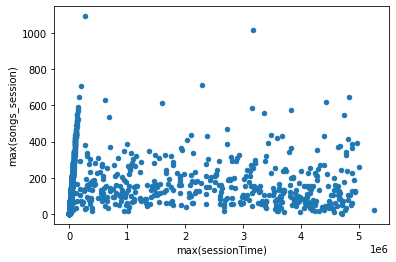

In [75]:
df_aux.plot.scatter('max(sessionTime)', 'max(songs_session)');

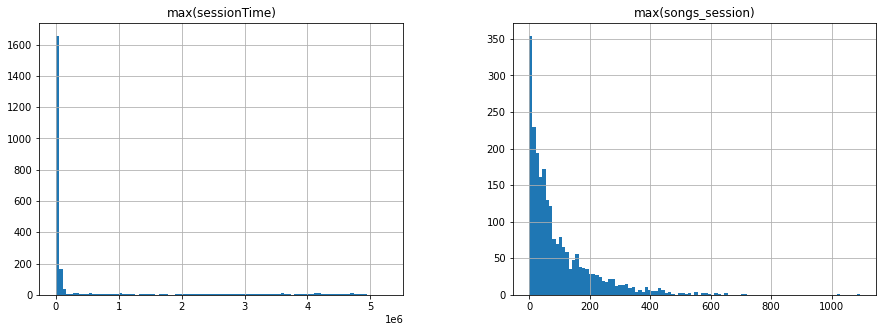

In [76]:
df_aux.hist(['max(sessionTime)', 'max(songs_session)'], bins=100, figsize=(15,5));

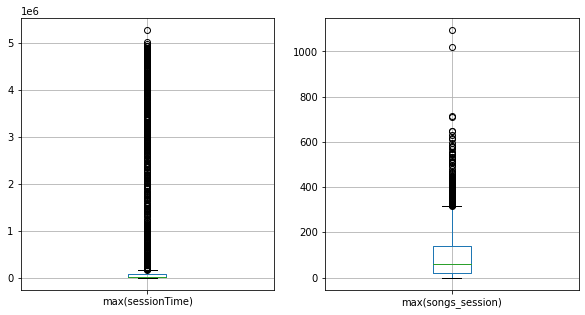

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_aux.boxplot('max(sessionTime)',ax=ax[0])
df_aux.boxplot('max(songs_session)',ax=ax[1]);

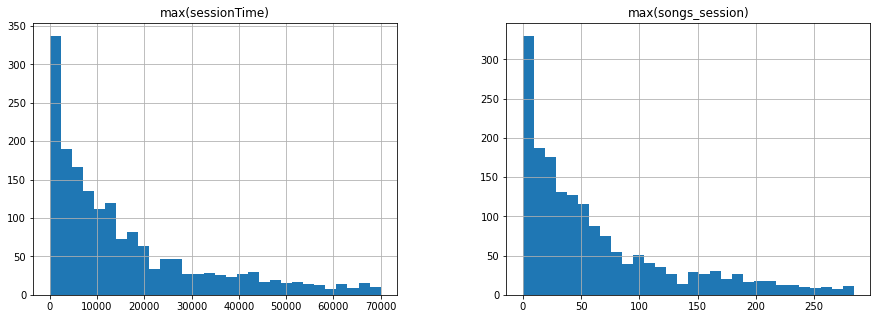

In [78]:
df_aux2 = df_songs.groupBy('sessionId').max('songs_session', 'sessionTime').filter(col('max(sessionTime)')<70000).toPandas()
df_aux2.set_index('sessionId', inplace=True)
df_aux2.hist(['max(sessionTime)', 'max(songs_session)'], bins=30, figsize=(15,5));

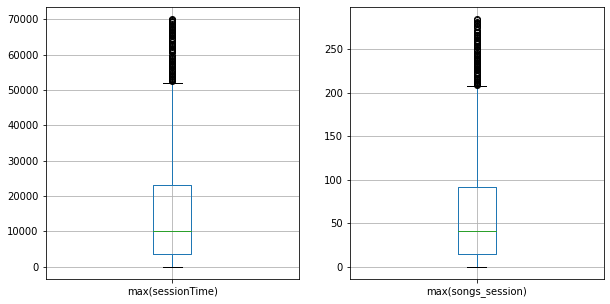

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
df_aux2.boxplot('max(sessionTime)',ax=ax[0])
df_aux2.boxplot('max(songs_session)',ax=ax[1]);

In [80]:
session_ids = list(df_aux2.index)
df_songs.filter(col('sessionId').isin(session_ids)).count()

135780

In [81]:
df_song_hour = df_songs.withColumn('songs_hour', col('songs_session')/(col('sessionTime')/(60*60)))
df_song_hour = df_song_hour.na.fill({'songs_hour':'0.0'})
df_song_hour.select('sessionId','songs_session', 'sessionTime', 'songs_hour').show()

+---------+-------------+-----------+------------------+
|sessionId|songs_session|sessionTime|        songs_hour|
+---------+-------------+-----------+------------------+
|        4|            0|          0|               0.0|
|        4|            1|         32|             112.5|
|        4|            2|        140| 51.42857142857143|
|        4|            3|        178| 60.67415730337079|
|        4|            4|        397|   36.272040302267|
|        4|            5|        579|31.088082901554404|
|        4|            6|        957|22.570532915360502|
|        4|            7|       1210|20.826446280991735|
|        4|            7|       1376|18.313953488372093|
|        4|            8|       1546|18.628719275549805|
|        4|            9|       1774| 18.26381059751973|
|        4|           10|       1993| 18.06322127446061|
|        4|           10|       2076|17.341040462427745|
|        4|           10|       2077| 17.33269138180067|
|        4|           10|      

In [82]:
df_song_hour.groupBy('sessionId').max('songs_session', 'sessionTime', 'songs_hour').sort(col('max(songs_hour)').desc()).show()

+---------+------------------+----------------+---------------+
|sessionId|max(songs_session)|max(sessionTime)|max(songs_hour)|
+---------+------------------+----------------+---------------+
|      827|               593|          147612|         3600.0|
|      150|                57|          780657|         3600.0|
|      168|                36|         1031730|         3600.0|
|      238|               242|         2547918|         3600.0|
|      240|               206|         2449732|         3600.0|
|      253|                83|         2604117|         3600.0|
|      263|                37|         2679559|         3600.0|
|      264|               189|         2733696|         3600.0|
|      301|                92|          895025|         3600.0|
|      373|                58|         4250002|         3600.0|
|      539|                54|           14469|         3600.0|
|      544|                13|            3444|         3600.0|
|      547|               111|          

In [83]:
df_song_hour.select('sessionId','songs_session', 'sessionTime', 'songs_hour', 'page').filter(col('sessionId')==168).show()

+---------+-------------+-----------+--------------------+----------+
|sessionId|songs_session|sessionTime|          songs_hour|      page|
+---------+-------------+-----------+--------------------+----------+
|      168|            1|          0|                 0.0|  NextSong|
|      168|            1|          1|              3600.0| Thumbs Up|
|      168|            2|        103|   69.90291262135922|  NextSong|
|      168|            3|        479|   22.54697286012526|  NextSong|
|      168|            4|        496|  29.032258064516128|  NextSong|
|      168|            5|        789|  22.813688212927755|  NextSong|
|      168|            5|        790|   22.78481012658228| Thumbs Up|
|      168|            6|        998|  21.643286573146295|  NextSong|
|      168|            6|        999|   21.62162162162162|Add Friend|
|      168|            7|       1225|   20.57142857142857|  NextSong|
|      168|            8|       1464|  19.672131147540984|  NextSong|
|      168|         

In [84]:
df_song_hour.groupBy('userId').count().sort(col('count').desc()).show(3)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
+------+-----+
only showing top 3 rows



In [85]:
df_song_hour.filter(col('userId')==39).select('page', 'sessionTime', 'songs_session', 'sessionId', 'ts').collect()

[Row(page='Home', sessionTime=0, songs_session=0, sessionId=276, ts=1538411191000),
 Row(page='NextSong', sessionTime=26, songs_session=1, sessionId=276, ts=1538411217000),
 Row(page='NextSong', sessionTime=412, songs_session=2, sessionId=276, ts=1538411603000),
 Row(page='NextSong', sessionTime=679, songs_session=3, sessionId=276, ts=1538411870000),
 Row(page='NextSong', sessionTime=866, songs_session=4, sessionId=276, ts=1538412057000),
 Row(page='Logout', sessionTime=867, songs_session=4, sessionId=276, ts=1538412058000),
 Row(page='NextSong', sessionTime=0, songs_session=1, sessionId=329, ts=1538481410000),
 Row(page='Settings', sessionTime=58, songs_session=1, sessionId=329, ts=1538481468000),
 Row(page='Home', sessionTime=132, songs_session=1, sessionId=329, ts=1538481542000),
 Row(page='NextSong', sessionTime=247, songs_session=2, sessionId=329, ts=1538481657000),
 Row(page='NextSong', sessionTime=479, songs_session=3, sessionId=329, ts=1538481889000),
 Row(page='Roll Advert', s

In [86]:
free_down = df_songs.filter((col('page')=='Thumbs Down') & (col('level')=='free')).count()
free_up = df_songs.filter((col('page')=='Thumbs Up') & (col('level')=='free')).count()
paid_down = df_songs.filter((col('page')=='Thumbs Down') & (col('level')=='paid')).count()
paid_up = df_songs.filter((col('page')=='Thumbs Up') & (col('level')=='free')).count()
print('free_up/free_down = ', free_up/free_down)
print('paid_up/paid_down = ', paid_up/paid_down)

free_up/free_down =  3.603588907014682
paid_up/paid_down =  1.1427832384893948


In [87]:
def count_pages(df, new_columns, pages, partition='sessionId'):
    
    assert len(new_columns) == len(pages)
    assert type(new_columns) == list
    assert type(pages) == list
    assert partition == 'sessionId' or partition == 'userId'
    
    windowval = (Window.partitionBy('sessionId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))
    
    for i in range(len(new_columns)):
        df = df.withColumn(new_columns[i]+'_bool', when(df.page == pages[i], 1)
                                           .otherwise(0))
        
        df = df.withColumn(new_columns[i], F.sum(new_columns[i]+'_bool').over(windowval))
        df = df.drop(new_columns[i]+'_bool')
        
    return df

In [88]:
def count_features(df, new_columns, features, partition='sessionId'):
    
    assert len(new_columns) == len(features)
    assert type(new_columns) == list
    assert type(features) == list
    assert partition == 'sessionId' or partition == 'userId'
    
    windowval = (Window.partitionBy('sessionId').orderBy('ts')
             .rangeBetween(Window.unboundedPreceding, 0))
    
    for i in range(len(new_columns)):
        df = df.withColumn(new_columns[i], F.sum(features[i]).over(windowval))

    return df

In [89]:
df_pre_final = count_pages(df_song_hour, ['tup_session', 'tdown_session', 'ads_session'], 
                           ['Thumbs Up', 'Thumbs Down', 'Roll Advert'])
df_pre_final = count_pages(df_pre_final, ['tup_user', 'tdown_user', 'ads_user'], 
                           ['Thumbs Up', 'Thumbs Down', 'Roll Advert'], partition='userId')

In [90]:
print("paid M/F: ",
    df_pre_final.filter((col('gender')=='M') & (col('level') == 'paid')).count()/\
    df_pre_final.filter((col('gender')=='F') & (col('level') == 'paid')).count())
print("free M/F: ",
    df_pre_final.filter((col('gender')=='M') & (col('level') == 'free')).count()/\
    df_pre_final.filter((col('gender')=='F') & (col('level') == 'free')).count())

paid M/F:  0.7808031639793125
free M/F:  0.8778983553518469


In [91]:
df_pre_final = df_pre_final.withColumn('male', when(col('gender')=='M', 1).otherwise(0))
df_pre_final = df_pre_final.withColumn('female', when(col('gender')=='F', 1).otherwise(0))

df_pre_final = df_pre_final.withColumn('paid', when(col('level')=='paid', 1).otherwise(0))
df_pre_final = df_pre_final.withColumn('free', when(col('gender')=='free', 1).otherwise(0))

In [92]:
df_pre_final.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_user: integer (nullable = false)
 |-- prev_ts: long (nullable = true)
 |-- deltaT: integer (nullable = true)
 |-- sessionTime: long (nullable = true)
 |-- userTime: long (nullable = true)
 |-- songs_session: long (nullable = false)
 |-- songs_user: long (nullable = false)
 |-- songs_hour: doubl

In [93]:
features = ['userId', 'itemInSession', 'male', 'female', 'paid', 'free', 'sessionTime', 'userTime', 
            'songs_session', 'songs_user', 'tup_session', 'tup_user', 'tdown_session', 'tdown_user', 
            'ads_session', 'ads_user', 'churn_user']
df_final = df_pre_final.select(*features[:-1], col('churn_user').alias('label'))
df_pandas = df_final.toPandas()
df_pandas

,userId,itemInSession,male,female,paid,free,sessionTime,userTime,songs_session,songs_user,tup_session,tup_user,tdown_session,tdown_user,ads_session,ads_user,label
0,100004,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,100004,1,0,1,0,0,32,32,1,1,0,0,0,0,0,0,1
2,100004,2,0,1,0,0,140,140,2,2,0,0,0,0,0,0,1
3,100004,3,0,1,0,0,178,178,3,3,0,0,0,0,0,0,1
4,100004,4,0,1,0,0,397,397,4,4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,95,20,0,1,0,0,3524,418714,15,1693,0,0,0,0,1,1,1
278150,95,21,0,1,0,0,3790,418980,16,1694,0,0,0,0,1,1,1
278151,95,22,0,1,0,0,3791,418981,16,1694,0,0,0,0,1,1,1
278152,95,25,0,1,0,0,3807,418997,16,1694,0,0,0,0,1,1,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [99]:
def split_users(df, test_size=0.3, seed=42):
    random.seed(seed)
    
    users = [u[0] for u in df_final.select('userId').distinct().collect()]
    test_size = int(len(users)*test_size)
    test_users = random.sample(users, test_size)
    train_users = [u for u in users if (u not in test_users)]
    
    df_test = df.filter(col('userId').isin(test_users))
    df_train = df.filter(col('userId').isin(train_users))
    
    return df_train, df_test

In [100]:
assembler = VectorAssembler(inputCols=features[1:-1], outputCol='features')
df_ml = assembler.transform(df_final)

scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
# scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(df_ml)
df_ml_scaled = scalerModel.transform(df_ml)

df_ml_scaled = df_ml_scaled.select('userId', 'features', 'scaledFeatures', 'label')

df_train, df_test = split_users(df_ml_scaled, 0.3)

In [101]:
tree = RandomForestClassifier(featuresCol='scaledFeatures', numTrees=30)

start_time = time.time()
tree_model = tree.fit(df_train)
print("Training time: {:.4f}s".format(time.time() - start_time))

pred = tree_model.transform(df_test)
evaluator = MulticlassClassificationEvaluator(metricName='f1')
ann_f1 = evaluator.evaluate(pred)
print("F1: ", ann_f1)
print("Acc: ", tree_model.summary.accuracy)

Training time: 7.9987s
F1:  0.5063574762398818
Acc:  0.7076403117592704


In [103]:
churn_dict = dict(pred.groupBy('userId').mean('prediction').collect())

In [108]:
from pyspark.sql.types import IntegerType, FloatType

userPredF = udf(lambda u: churn_dict[u], FloatType())
pred2 = pred.withColumn('userPred', userPredF(col('userId')))

In [105]:
train_features = ['itemInSession', 'male', 'female', 'paid', 'free', 'sessionTime', 'userTime', 
                  'songs_session', 'songs_user', 'tup_session', 'tup_user', 'tdown_session', 
                  'tdown_user', 'ads_session', 'ads_user']

df_train, df_test = split_users(df_final, 0.3)

assembler = VectorAssembler(inputCols=train_features, outputCol='vectorFeatures')
scaler = MinMaxScaler(inputCol='vectorFeatures', outputCol='scaledFeatures')
classifier = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', layers=[15, 64, 2], 
                                            maxIter=100, stepSize = 0.05)

paramGrid = ParamGridBuilder() \
                .addGrid(classifier.maxIter, [200, 500, 1000]) \
                .addGrid(classifier.stepSize, [0.03, 0.06, 0.12]) \
                .build()

tvs = TrainValidationSplit(estimator=classifier,
                       parallelism=5,
                       estimatorParamMaps=paramGrid,
                       evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                       trainRatio=0.75)

pipeline = Pipeline(stages=[assembler, scaler, tvs])

start_time = time.time()
model = pipeline.fit(df_train)
print('p: {} | {:.2f}s'.format(p, time.time() - start_time))

p: 9 | 562.11s


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.